Based on: https://towardsdatascience.com/estimating-probabilities-with-bayesian-modeling-in-python-7144be007815

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
from scipy.stats import dirichlet
from numpy import ndarray
from numpy.random import RandomState
from dask import compute

sns.set_style("darkgrid")
sns.set_palette("muted")

In [2]:
rand = RandomState(seed=123)

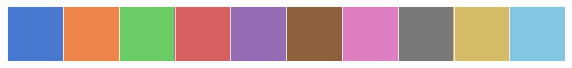

In [42]:
palette = sns.color_palette()
sns.palplot(palette)

# Helpers

In [51]:
def display_probs(labels, probs) -> None:
    for i, lab in enumerate(labels):
        print(f"Label: {lab}\t\tProb: {probs[i]}")

        
def dir_mult_ev(c, alphas) -> float:
    return (c + alphas) / (c.sum() + alphas.sum())


def dir_mult_map(c, alphas) -> float:
    return (alphas + c - 1) / np.sum(alphas + c - 1)


def melt_and_bar_plot(d_frame, ax) -> None:
    melted_df = pd.melt(d_frame, id_vars="alphas", var_name="species", value_name="prevalence")
    sns.barplot(x="alphas", y="prevalence", hue="species", data=melted_df, ax=ax)

    
def color_code_and_legend(ax, n_lines, pal, leg):
    lines = ax.get_lines()[:n_lines]
    for i in range(n_lines):
        lines[i].set_color(pal[i])
    ax.legend(leg, loc=1)

# Define parameters & observations

In [4]:
# Observed data
animals = ["lions", "tigers", "bears"]
c = np.array([3, 2, 1])
n = c.sum()

# Hyperparameters (assume uniform)
alphas = np.array([
    np.array([0.1, 0.1, 0.1]),
    np.array([1, 1, 1]),
    np.array([5, 5, 5]),
    np.array([15, 15, 15])
])

# Expected Value

In [5]:
ev = dir_mult_ev(c, alphas[1])
display_probs(animals, ev)

Label: lions		Prob: 0.4444444444444444
Label: tigers		Prob: 0.3333333333333333
Label: bears		Prob: 0.2222222222222222


In [6]:
evs = compute(np.array([dir_mult_ev(c, a) for a in alphas]))[0]
df = pd.DataFrame(evs, columns=animals)
df["alphas"] = [str(x) for x in alphas]
df

,lions,tigers,bears,alphas
0,0.492063,0.333333,0.174603,[0.1 0.1 0.1]
1,0.444444,0.333333,0.222222,[1. 1. 1.]
2,0.380952,0.333333,0.285714,[5. 5. 5.]
3,0.352941,0.333333,0.313725,[15. 15. 15.]


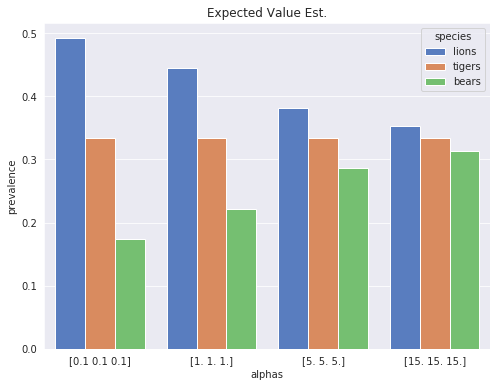

In [7]:
_, ax = plt.subplots(figsize=(8, 6))
melt_and_bar_plot(df, ax)
ax.set_title("Expected Value Est.")
plt.show()

# MAP

In [8]:
map_ests = dir_mult_map(c, alphas[1])
display_probs(animals, map_ests)

Label: lions		Prob: 0.5
Label: tigers		Prob: 0.3333333333333333
Label: bears		Prob: 0.16666666666666666


In [9]:
map_ests = compute(np.array([dir_mult_map(c, a) for a in alphas]))[0]
df = pd.DataFrame(map_ests, columns=animals)
df["alphas"] = [str(x) for x in alphas]
df

,lions,tigers,bears,alphas
0,0.636364,0.333333,0.030303,[0.1 0.1 0.1]
1,0.500000,0.333333,0.166667,[1. 1. 1.]
2,0.388889,0.333333,0.277778,[5. 5. 5.]
3,0.354167,0.333333,0.312500,[15. 15. 15.]


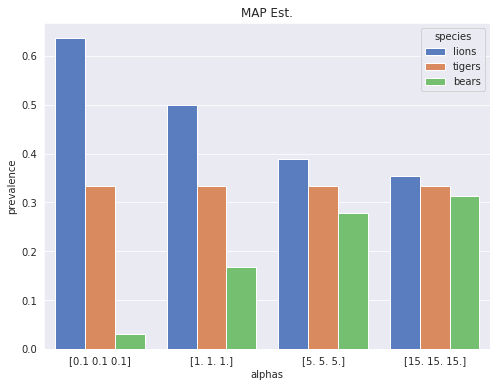

In [10]:
_, ax = plt.subplots(figsize=(8, 6))
melt_and_bar_plot(df, ax)
ax.set_title("MAP Est.")
plt.show()

# Bayesian Modeling
Goal: quantify uncertainty of model

In [11]:
with pm.Model() as model:
    # Parameters of the Multinomial drawn from a Dirichlet
    params = pm.Dirichlet("parameters", a=alphas[1], shape=3)
    # Observations from a Multinomial distribution
    observations = pm.Multinomial("observations", n=6, p=params, shape=3, observed=c)

In [12]:
model

# Sampling from the model

In [13]:
with model:
    # Sample from the posterior
    trace = pm.sample(draws=1000, chains=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 4 jobs)
NUTS: [parameters]
Sampling 3 chains, 0 divergences: 100%|██████████| 4500/4500 [00:01<00:00, 3716.17draws/s]


In [14]:
summary = pm.summary(trace, credible_interval=.95)
summary.index = animals
summary

,mean,sd,hpd_2.5%,hpd_97.5%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lions,0.446,0.160,0.157,0.756,0.003,0.002,2538.0,2377.0,2504.0,2071.0,1.0
tigers,0.332,0.151,0.051,0.618,0.003,0.002,2685.0,2464.0,2682.0,2134.0,1.0
bears,0.221,0.133,0.015,0.486,0.003,0.002,2345.0,2082.0,2293.0,1912.0,1.0


In [15]:
trace_df = pd.DataFrame(trace["parameters"], columns=animals)
trace_df.head()

,lions,tigers,bears
0,0.414988,0.299017,0.285995
1,0.344066,0.289190,0.366744
2,0.597676,0.287203,0.115121
3,0.238946,0.483148,0.277906
4,0.631417,0.147014,0.221569


In [16]:
trace_df.shape

(3000, 3)

In [17]:
pv = trace_df.mean(axis=0)
display_probs(animals, pv)

Label: lions		Prob: 0.44635996740120726
Label: tigers		Prob: 0.3324686091219796
Label: bears		Prob: 0.22117142347681187


In [18]:
summary[["hpd_2.5%", "hpd_97.5%"]]

,hpd_2.5%,hpd_97.5%
lions,0.157,0.756
tigers,0.051,0.618
bears,0.015,0.486


# Visualizations

## Posterior

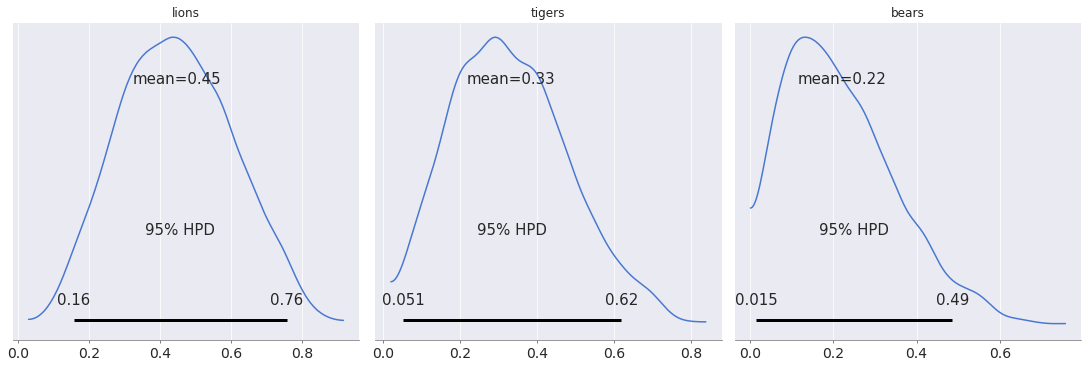

In [19]:
axes = pm.plot_posterior(trace, var_names=["parameters"], figsize=(15, 5), credible_interval=0.95)
for i, a in enumerate(animals):
    axes[i].set_title(a)
plt.show()

# Traceplot

/home/carcook/anaconda3/envs/data-science-env/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/carcook/anaconda3/envs/data-science-env/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"
/home/carcook/anaconda3/envs/data-science-env/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


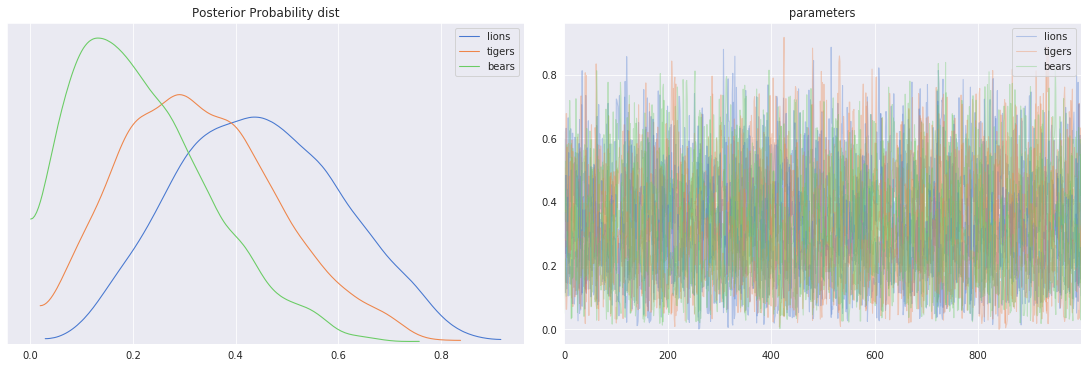

In [54]:
axes = pm.traceplot(trace, var_names=["parameters"], figsize=(15, 5), combined=True)
axes[0][0].set_title("Posterior Probability dist")
color_code_and_legend(axes[0][0], 3, palette, animals)
color_code_and_legend(axes[0][1], 3, palette, animals)
plt.show()

# MAP with PyMC3

In [55]:
with model:
    maxapost = pm.find_MAP()

logp = -1.8042, ||grad|| = 1.118: 100%|██████████| 7/7 [00:00<00:00, 1283.56it/s]


In [57]:
display_probs(animals, maxapost["parameters"])

Label: lions		Prob: 0.4999999599472019
Label: tigers		Prob: 0.33333301020241707
Label: bears		Prob: 0.166667029850381
